# Richter's Predictor: Modeling Earthquake Damage

Based on aspects of building location and construction, the goal is to predict the level of damage to buildings caused by the 2015 Gorkha earthquake in Nepal.

The data was collected through surveys by [Kathmandu Living Labs](http://www.kathmandulivinglabs.org) and the [Central Bureau of Statistics](https://cbs.gov.np), which works under the National Planning Commission Secretariat of Nepal. This survey is **one of the largest post-disaster datasets ever collected**, containing valuable information on earthquake impacts, household conditions, and socio-economic-demographic statistics.

In [1]:
import pandas as pd
import numpy as np
import os
import re

import string 
import seaborn as sns 
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# ! pip install imbalanced-learn
import imblearn
# print(imblearn.__version__)
from imblearn.over_sampling import SMOTE

In [3]:
import sklearn

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold

from sklearn.pipeline import Pipeline

from sklearn import metrics
from sklearn.metrics import classification_report, f1_score, roc_auc_score, roc_curve, confusion_matrix

from sklearn.ensemble import RandomForestClassifier

import multiprocessing

In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [5]:
# Load data set
train = pd.read_csv(os.path.join('', 'Richters_Predictor_Modeling_Earthquake_Damage_-_Train_Values.csv'))

In [6]:
test = pd.read_csv(os.path.join('', 'Richters_Predictor_Modeling_Earthquake_Damage_-_Test_Values.csv'))

In [7]:
labels = pd.read_csv(os.path.join('', 'Richters_Predictor_Modeling_Earthquake_Damage_-_Train_Labels.csv'))

In [8]:
labels.damage_grade.value_counts()/len(labels.damage_grade)

2    0.568912
3    0.334680
1    0.096408
Name: damage_grade, dtype: float64

**Remarks:**

- According to these results, we can say that there are 56.89% of the building suffered a medium amount of damage, 33.46% of the building were almost completely distructed and 9.64% of the building suffered a low damage.

- Class "low damage" is imbalanced, and might need upsampling. Another option to deal with the imbalance is to choose an appropriate metric, like F1 score or AUC.

In [9]:
train.dtypes.value_counts()

int64     31
object     8
dtype: int64

In [10]:
print('Object data types:\n')
#we'll use the function later, without wanting to print anything
def get_obj(train, p = False):
    obj_types = []
    for column in train.columns:
        if train[column].dtype == 'object': 
            if p: print(column)
            obj_types.append(column)
    return obj_types

Object data types:



In [11]:
obj_types = get_obj(train, True)

land_surface_condition
foundation_type
roof_type
ground_floor_type
other_floor_type
position
plan_configuration
legal_ownership_status


In [12]:
def transform_to_int(train, obj_types):
    #Assign dictionaries with current values and replacements for each column
    d_lsc = {'n':0, 'o':1, 't':2}
    d_ft = {'h':0, 'i':1, 'r':2, 'u':3, 'w':4}
    d_rt = {'n':0, 'q':1, 'x':2}
    d_gft = {'f':0, 'm':1, 'v':2, 'x':3, 'z':4}
    d_oft = {'j':0, 'q':1, 's':2, 'x':3}
    d_pos = {'j':0, 'o':1, 's':2, 't':3}
    d_pc = {'a':0, 'c':1, 'd':2, 'f':3, 'm':4, 'n':5, 'o':6, 'q':7, 's':8, 'u':9}
    d_los = {'a':0, 'r':1, 'v':2, 'w':3}
    #Each positional index in replacements corresponds to the column in obj_types
    replacements = [d_lsc, d_ft, d_rt, d_gft, d_oft, d_pos, d_pc, d_los]

    #Replace using lambda Series.map(lambda)
    for i,col in enumerate(obj_types):
        train[col] = train[col].map(lambda a: replacements[i][a]).astype('int64')

In [13]:
transform_to_int(train, obj_types)

In [14]:
train.dtypes.value_counts()

int64    39
dtype: int64

In [15]:
train.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,2,2,0,0,1,3,2,1,1,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,1,2,0,3,1,2,2,0,1,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,2,2,0,0,3,3,2,0,1,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,2,2,0,0,3,2,2,0,1,0,0,0,0,1,1,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,2,2,0,0,3,2,2,1,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0


***
**Data Splitting**
***

In [16]:
y = labels.pop('damage_grade')  
x = train.drop(["building_id"],axis=1)

In [17]:
print('Original dataset shape:', x.shape)
print('Original labelset shape:', y.shape)

Original dataset shape: (260601, 38)
Original labelset shape: (260601,)


In [18]:
# keep the same random state for reproducibility
RANDOM_STATE = 12
TRAIN_TEST_SPLIT_SIZE = .1

In [19]:
# stratify on damage_grade
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size = TRAIN_TEST_SPLIT_SIZE, 
                                                    stratify = y,
                                                    random_state = RANDOM_STATE)

In [20]:
print('Training dataset shape:', x_train.shape)
print('Training labelset shape:', y_train.shape)

Training dataset shape: (234540, 38)
Training labelset shape: (234540,)


In [21]:
print('Test labelset shape:', y_test.shape)
print('Test dataset shape:', x_test.shape)

Test labelset shape: (26061,)
Test dataset shape: (26061, 38)


Scaling is typically done to normalize data so that priority is not given to a particular feature. The role of scaling is mostly important in algorithms that are distance based and require Euclidean Distance. Random Forest is a tree-based model and hence does not require feature scaling.

***
**Functions**
***

In [25]:
def check_model_and_test(x_train, y_train, x_test, y_test, classifiers):
    for model in classifiers:
        this_model = model.__class__.__name__ #get the name of the classifier
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        
        print(f'{this_model} f1 score:')
        score = f1_score(y_test, y_pred, average='micro')
        print(f'{score:.4f}')
        print('\n')

***
**Random Forest**
***
Random Forest is an ensemble bagging model. It creates a set of decision trees from randomly selected subset of training set and then aggregates the votes from different decision trees to decide the final class of the test object. In that way, random forest will get lower variance compared to decision tree because the decision tree is more sensitive to specific data and only one single decision tree is built. Moreover, random forest will get less overfit issues even when the number of trees is increased. 

Most generally, a hyperparameter is a parameter of the model that is set prior to the start of the learning process. Different models have different hyperparameters that can be set. For a Random Forest Classifier, there are several different hyperparameters that can be adjusted. For now I will concentrate on the following four parameters:
1. **n_estimators**: The n_estimators parameter specifies the number of trees in the forest of the model. The default value for this parameter is 10, which means that 10 different decision trees will be constructed in the random forest.
2. **max_depth**: The max_depth parameter specifies the maximum depth of each tree. The default value for max_depth is None, which means that each tree will expand until every leaf is pure. A pure leaf is one where all of the data on the leaf comes from the same class.
3. **min_samples_split**: The min_samples_split parameter specifies the minimum number of samples required to split an internal leaf node. The default value for this parameter is 2, which means that an internal node must have at least two samples before it can be split to have a more specific classification.
4. **min_samples_leaf**: The min_samples_leaf parameter specifies the minimum number of samples required to be at a leaf node. The default value for this parameter is 1, which means that every leaf must have at least 1 sample that it classifies.


In [26]:
# Create the random grid
random_grid = {
               # Number of trees in random forest
               'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)],
               # Number of features to consider at every split
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}
print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


On each iteration, the algorithm will choose a difference combination of the features. Altogether, there are 10 * 2 * 11 * 3 * 3 * 2 settings! However, the benefit of a random search is that we are not trying every combination, but selecting at random to sample a wide range of values.

A common extension of randomized/grid search is to use it alongside cross validation, training on several different folds for each hyperparameter combination to have a more reliable estimate of each model’s performance out of sample. 

K-fold cross validation works by breaking the training data into K equal-sized “folds.” It iterates through each fold, treating that fold as holdout data, training a model on all the other K-1 folds, and evaluating the model’s performance on the one holdout fold. This results in having K different models, each with an out of sample model accuracy score on a different holdout set. The average of these K models’ out-of-sample scores is the model’s cross-validation score.

Cross validation is useful because it provides a lower-variance estimate of the model’s true out of sample score than if you had only used a single train-test split.

Here I will use a stratified K-fold cross validation to preserve the distribution of classes, due to the imbalance in the dataset and set the number of fold to 3, since I already have a test set. In reality it is advisable to keep a completely separate, unseen test set because during the grid search process some information about the dataset, over which we perform a grid search leaks into the hyperparameters. To get a final, unbiased performance on the new data we need to hold out a sample of a dataset which was never seen by fit classifier - ever, directly or indirectly. 

In [27]:
kf_2_cv = StratifiedKFold(n_splits = 2, random_state = RANDOM_STATE, shuffle = True)

In [28]:
kf_5_cv = StratifiedKFold(n_splits = 5, random_state = RANDOM_STATE, shuffle = True)

In [29]:
rf_clf = RandomForestClassifier()

The most important arguments in RandomizedSearchCV are n_iter, which controls the number of different combinations to try, and cv which is the number of folds to use for cross validation (we use 100 and 3 respectively). More iterations will cover a wider search space and more cv folds reduces the chances of overfitting, but raising each will increase the run time. Machine learning is a field of trade-offs, and performance vs time is one of the most fundamental.

In [30]:
rf_random = RandomizedSearchCV(estimator = rf_clf, param_distributions = random_grid, n_iter = 100, cv = kf_2_cv, scoring = 'f1_micro', verbose = 5, random_state = RANDOM_STATE, n_jobs = 1)

In [31]:
# Fit the random search model
rf_random.fit(x_train, y_train)

Fitting 2 folds for each of 100 candidates, totalling 200 fits
[CV 1/2] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.1min
[CV 2/2] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.1min
[CV 1/2] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 1.9min
[CV 2/2] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 1.4min
[CV 1/2] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time= 2.7min
[CV 2/2] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time= 2.9min
[CV 1/2] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samp

[CV 1/2] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time= 3.1min
[CV 2/2] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time= 3.1min
[CV 1/2] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  47.5s
[CV 2/2] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  47.4s
[CV 1/2] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time= 3.6min
[CV 2/2] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time= 3.9min
[CV 1/2] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 2.6min
[CV 2/2] END 

[CV 2/2] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  45.7s
[CV 1/2] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time= 3.1min
[CV 2/2] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time= 3.1min
[CV 1/2] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 2.8min
[CV 2/2] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 2.8min
[CV 1/2] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  34.3s
[CV 2/2] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  34.0s
[CV 1/2] E

[CV 1/2] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600; total time= 2.0min
[CV 2/2] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600; total time= 2.0min
[CV 1/2] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time= 1.7min
[CV 2/2] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time= 1.7min
[CV 1/2] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=  40.2s
[CV 2/2] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=  39.5s
[CV 1/2] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time= 2.2min
[CV 2/2] END boots

RandomizedSearchCV(cv=StratifiedKFold(n_splits=2, random_state=12, shuffle=True),
                   estimator=RandomForestClassifier(), n_iter=100, n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=12, scoring='f1_micro', verbose=5)

We can view the best parameters from fitting the random search:

In [32]:
rf_random.best_score_

0.7229598362752621

In [33]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 110,
 'bootstrap': False}

From these results, we should be able to narrow the range of values for each hyperparameter.

In [34]:
best_random = rf_random.best_estimator_

Random search allowed us to narrow down the range for each hyperparameter. Now that we know where to concentrate our search, we can explicitly specify different combinations of settings to try (concentrated around the best parameters from the randomized search). 

We do this with GridSearchCV, a method which instead of sampling randomly from a distribution, evaluates all combinations that we define. We feed it a set of hyperparameters and the values we want to test for each hyperparameter, and then run an exhaustive search over all possible combinations of these values, training one model for each set of values. The algorithm then compares the scores of each model it trains and keeps the best one. To use Grid Search, we make another parameter grid based on the best values provided by random search.

In [43]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [110, 120, 130],
    'max_features': ['sqrt'],
    'min_samples_split': [10],
    'min_samples_leaf': [1],
    'n_estimators': [500, 600]
}
print(param_grid)

{'bootstrap': [True], 'max_depth': [110, 120, 130], 'max_features': ['sqrt'], 'min_samples_split': [10], 'min_samples_leaf': [1], 'n_estimators': [500, 600]}


In [44]:
cores = multiprocessing.cpu_count() # Count the number of cores in the computer

In [47]:
rf_cv = GridSearchCV(estimator = rf_clf, param_grid = param_grid, cv = kf_5_cv, scoring = 'f1_micro', verbose = 5, n_jobs = 1)

In [48]:
rf_cv.fit(x_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time= 3.3min
[CV 2/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time= 3.2min
[CV 3/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time= 3.3min
[CV 4/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time= 3.1min
[CV 5/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time= 3.1min
[CV 1/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time= 3.8min
[CV 2/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_s

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=12, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=1,
             param_grid={'bootstrap': [True], 'max_depth': [110, 120, 130],
                         'max_features': ['sqrt'], 'min_samples_leaf': [1],
                         'min_samples_split': [10],
                         'n_estimators': [500, 600]},
             scoring='f1_micro', verbose=5)

In [49]:
rf_cv.best_params_ 

{'bootstrap': True,
 'max_depth': 110,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 500}

In [50]:
rf_cv.best_score_

0.7305235780677071

In [51]:
rf = rf_cv.best_estimator_

In [52]:
rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_test)

In [53]:
score = f1_score(y_test, y_pred_rf, average='micro')
print(f'{score:.4f}')

0.7314


(array([0.5, 1.5, 2.5]), <a list of 3 Text major ticklabel objects>)

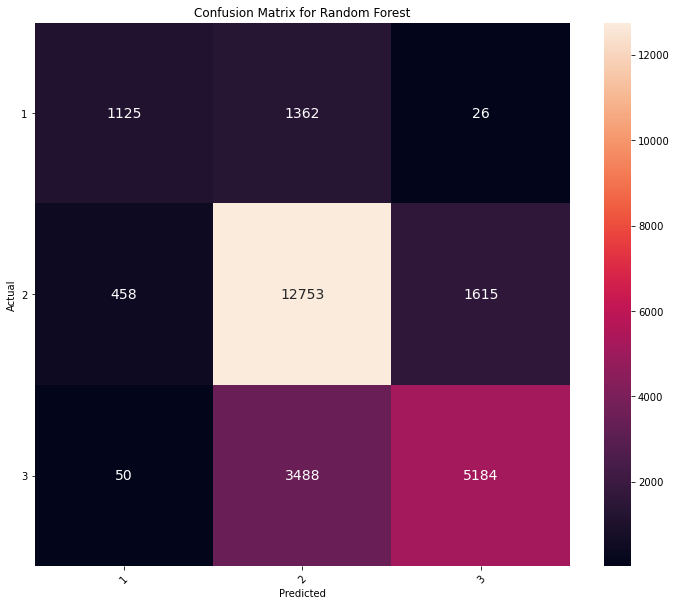

In [54]:
df_cm_rf = pd.DataFrame(confusion_matrix(y_test, y_pred_rf), columns=np.unique(y_test), index = np.unique(y_test))
df_cm_rf.index.name = 'Actual'
df_cm_rf.columns.name = 'Predicted'

sns.heatmap(df_cm_rf, annot=True, fmt='d', annot_kws={"size": 14})
plt.title("Confusion Matrix for Random Forest")
plt.xticks(rotation=45)
plt.yticks(rotation=360)

In [55]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           1       0.69      0.45      0.54      2513
           2       0.72      0.86      0.79     14826
           3       0.76      0.59      0.67      8722

    accuracy                           0.73     26061
   macro avg       0.72      0.63      0.67     26061
weighted avg       0.73      0.73      0.72     26061



In [57]:
importance_rf = pd.DataFrame({"Features":x.columns, "Importance_RF":rf.feature_importances_}).sort_values(by='Importance_RF', ascending = False).head(15)

rf_styler = importance_rf.style.set_table_attributes("style='display:inline'").set_caption('Top 15 Random Forest importance')

from IPython.display import display_html 
display_html(rf_styler._repr_html_(), raw=True)

,Features,Importance_RF
0,geo_level_1_id,0.192031
1,geo_level_2_id,0.142428
2,geo_level_3_id,0.132869
4,age,0.081107
5,area_percentage,0.076801
6,height_percentage,0.049411
8,foundation_type,0.031962
9,roof_type,0.028079
15,has_superstructure_mud_mortar_stone,0.023885
26,count_families,0.022943


Machine learning still suffers from a black box problem, and one image is not going to solve the issue! Nonetheless, looking at an individual decision tree shows us this model (and a random forest) is not an unexplainable method, but a sequence of logical questions and answers — much as we would form when making predictions. 

In [58]:
import joblib
# save
joblib.dump(rf, "./rf.joblib")

['./rf.joblib']

In [59]:
# load, no need to initialize the loaded model
loaded_rf = joblib.load("./rf.joblib")

In [60]:
transform_to_int(test, obj_types)

In [61]:
test = test.drop(["building_id"],axis=1)

In [62]:
predictions = rf.predict(test)

In [63]:
submission_format = pd.read_csv('Richters_Predictor_Modeling_Earthquake_Damage_-_Submission_Format.csv', index_col='building_id')

In [64]:
my_submission = pd.DataFrame(data = predictions,
                             columns = submission_format.columns,
                             index = submission_format.index)

In [65]:
my_submission.head()

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,1
421793,3


In [66]:
my_submission.to_csv('submission.csv')

In [67]:
!head submission.csv

building_id,damage_grade
300051,3
99355,2
890251,2
745817,1
421793,3
871976,2
691228,1
896100,3
343471,2
